# NBA Data: Modeling

Knowing the amount of number of 2-point shots, 3-point shots, and free-throws, should theoretically predict the winner of a basketball game with 100% accuracy because the team that scores the most points wins and those are all 3 ways to score points. I could throw all of my dependent variables in the model and have something incredibly accurate but that doesn't help teams strategize in this hypothetical scenario because that would essentily say "The team that wins in every possible stat category will win the game" which is obvious.

The value of this model is to provide guidance in team building and training. No team is ever \#1 in every stat category. That's not feasable. Instead I'm going to limit the model to only 3 inputs. This way, a caoch and go to their team and say "This year, we will focus on 3 things". Keep it simple for the team so they don't get scatterbrained trying to do too much. 

First, I will build the model to predict winning using all inputs. Then I will look at the feature importance to extract the 3 most useful features to predict winning. Finally, I will rebuild the model using only those 3 features. I will repeat this process for two to three different models to find the best combination of model and features to predict winning.

Model
Explanation
All features
use just best parameters (3
rebuild with 3
cross validation somewhere on training set
test set

## Imports

In [1]:
from mizani.formatters import * # this has various scales

import numpy as np
import pandas as pd
import pickle
from plotnine import *
import plotnine
import plydata.cat_tools as cat
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import warnings

plotnine.options.figure_size = (20, 10)
warnings.filterwarnings("ignore")

## Load Data

In [2]:
nba_df = pickle.load(open("data_clean/nba_df3.pkl", "rb"))
X_train_scaled = pickle.load(open("data_clean/X_train_scaled.pkl", "rb"))
X_test_scaled = pickle.load(open("data_clean/X_test_scaled.pkl", "rb"))
y_train = pickle.load(open("data_clean/y_train.pkl", "rb"))
y_test = pickle.load(open("data_clean/y_test.pkl", "rb"))

## Circling Back

After running a few tests I realized that including a metric for field goals which is just the summation of 2-point and 3-point field goals is reudnant. So I'm going to remove the fga and fg_pct inputs while keeping the more detailed 2-point and 3-point related inputs.

In [3]:
nba_df = nba_df.drop(columns = ["fga", "fg_pct"])
X_train_scaled = X_train_scaled.drop(columns = ["fga", "fg_pct"])
X_test_scaled = X_test_scaled.drop(columns = ["fga", "fg_pct"])
nba_df

,fg2a,fg2_pct,fg3a,fg3_pct,fta,ft_pct,reb,ast,stl,blk,to,pf,win
0,68.0,0.470588,8.0,0.250000,30.0,0.500000,38.0,20.0,9.0,4.0,18.0,34.0,loss
1,63.0,0.492063,7.0,0.142857,34.0,0.735294,41.0,23.0,8.0,4.0,18.0,26.0,win
2,66.0,0.545455,15.0,0.266667,34.0,0.617647,48.0,25.0,18.0,7.0,25.0,35.0,win
3,62.0,0.483871,13.0,0.153846,40.0,0.700000,43.0,20.0,9.0,4.0,24.0,26.0,loss
4,71.0,0.478873,6.0,0.666667,29.0,0.689655,52.0,25.0,10.0,7.0,25.0,33.0,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51332,75.0,0.346667,22.0,0.363636,24.0,0.833333,55.0,20.0,5.0,7.0,8.0,22.0,loss
51333,59.0,0.440678,41.0,0.365854,21.0,0.857143,40.0,30.0,9.0,4.0,14.0,19.0,loss
51334,65.0,0.615385,28.0,0.500000,26.0,0.769231,52.0,34.0,7.0,9.0,15.0,20.0,win
51335,60.0,0.500000,34.0,0.352941,20.0,0.800000,48.0,30.0,7.0,7.0,21.0,23.0,loss


## Model 1: Logistic Regression

The first model I will try is Logistic Regression. My output variable is win vs loss so I have to stick with categorical models and with this output variable being dichotomous, it makes sense to try Logistic Regression first.

### Hyperparameter Tuning

In [4]:
log_reg = LogisticRegression(random_state = 610)

param_grid = {"solver": ["liblinear", "sag", "saga"], 
              "C": np.arange(0.5, 5.1, 0.1), 
              "max_iter": np.arange(100, 600, 100)}

grid = GridSearchCV(log_reg, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=610),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
                         'max_iter': array([100, 200, 300, 400, 500]),
                         'solver': ['liblinear', 'sag', 'saga']})

### Model Creation

In [5]:
# Logistic Regression does not have a top_featurers attribute so I made one manually
# https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model
# https://stackoverflow.com/questions/24255723/sklearn-logistic-regression-important-features

log_reg = LogisticRegression(solver = grid.best_estimator_.solver, 
                             max_iter = grid.best_estimator_.max_iter, 
                             C = grid.best_estimator_.C, 
                             random_state = 610)

log_reg.fit(X_train_scaled, y_train)

log_reg_feature_list = np.abs(np.std(X_train_scaled) * log_reg.coef_[0]).sort_values(ascending = False) 
log_reg_top_features = list(log_reg_feature_list[0:3].index)

log_reg_feature_list

reb        2.140386
fg3a       1.857496
fg2a       1.484649
fg2_pct    1.303869
to         1.197492
fg3_pct    1.195557
stl        1.029783
ft_pct     0.441442
ast        0.436797
blk        0.281112
fta        0.253163
pf         0.218337
dtype: float64

### Model Evaluation

In [6]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(log_reg, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, log_reg.predict(X_test_scaled)))

Cross Validation Mean Score: 0.8333 (Std: 0.0061)
Classification Report for Test Data
              precision    recall  f1-score   support

        loss       0.83      0.83      0.83      7693
         win       0.83      0.83      0.83      7706

    accuracy                           0.83     15399
   macro avg       0.83      0.83      0.83     15399
weighted avg       0.83      0.83      0.83     15399



In [7]:
evaluation_metrics = pd.array(["model", "top_features", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

log_reg_evaluation = pd.array(["Logistic Regression", 
                               log_reg_top_features,
                               round(np.mean(scores), 4), 
                               round(np.std(scores), 4), 
                               round(accuracy_score(log_reg.predict(X_test_scaled), y_test), 4), 
                               round(precision_score(log_reg.predict(X_test_scaled), y_test, pos_label = 'win'), 4), 
                               round(recall_score(log_reg.predict(X_test_scaled), y_test, pos_label = 'win'), 4), 
                               round(f1_score(log_reg.predict(X_test_scaled), y_test, pos_label = 'win'), 4)])

log_reg_evaluation = pd.DataFrame(log_reg_evaluation, evaluation_metrics).transpose()
log_reg_evaluation

,model,top_features,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,Logistic Regression,"[reb, fg3a, fg2a]",0.8333,0.0061,0.8315,0.8332,0.8306,0.8319


## Model 2: Decision Tree

The second model I will try is a Decision Tree. Again, I need to stick to classification models. Decision Trees are beneficial in that they are easier to interpret.

### Hyperparameter Tuning

In [23]:
dec_tree = DecisionTreeClassifier(random_state = 610)

param_grid = {"criterion": ["gini", "entropy", "log_loss"], 
              "max_depth": np.append(np.arange(10, 110, 10), None)}

grid = GridSearchCV(dec_tree, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=610),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], dtype=object)})

### Model Creation

In [9]:
dec_tree = DecisionTreeClassifier(criterion = grid.best_estimator_.criterion, 
                                  max_depth = grid.best_estimator_.max_depth, 
                                  random_state = 610)

dec_tree.fit(X_train_scaled, y_train)

dec_tree_feature_list = pd.Series(dec_tree.feature_importances_, index = dec_tree.feature_names_in_).sort_values(ascending = False) 
dec_tree_top_features = list(dec_tree_feature_list[0:3].index)

dec_tree_feature_list

fg2_pct    0.237207
fg3_pct    0.217037
reb        0.213409
fg3a       0.062745
to         0.062611
stl        0.056634
fta        0.043069
ft_pct     0.036614
pf         0.022369
blk        0.020748
fg2a       0.016115
ast        0.011441
dtype: float64

### Model Evaluation

In [10]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(dec_tree, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, dec_tree.predict(X_test_scaled)))

Cross Validation Mean Score: 0.7422 (Std: 0.0065)
Classification Report for Test Data
              precision    recall  f1-score   support

        loss       0.74      0.75      0.75      7693
         win       0.75      0.74      0.75      7706

    accuracy                           0.75     15399
   macro avg       0.75      0.75      0.75     15399
weighted avg       0.75      0.75      0.75     15399



In [11]:
evaluation_metrics = pd.array(["model", "top_features", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

dec_tree_evaluation = pd.array(["Decision Tree", 
                               dec_tree_top_features,
                               round(np.mean(scores), 4), 
                               round(np.std(scores), 4), 
                               round(accuracy_score(dec_tree.predict(X_test_scaled), y_test), 4), 
                               round(precision_score(dec_tree.predict(X_test_scaled), y_test, pos_label = 'win'), 4), 
                               round(recall_score(dec_tree.predict(X_test_scaled), y_test, pos_label = 'win'), 4), 
                               round(f1_score(dec_tree.predict(X_test_scaled), y_test, pos_label = 'win'), 4)])

dec_tree_evaluation = pd.DataFrame(dec_tree_evaluation, evaluation_metrics).transpose()
dec_tree_evaluation

,model,top_features,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,Decision Tree,"[fg2_pct, fg3_pct, reb]",0.7422,0.0065,0.7455,0.7429,0.7471,0.745


## Model 3: Random Forest

The last model I will try is the Random Forest. This is more powerful than a single Decision Tree, however it loses out on interpretability. Fortunately in this scenario, the details of how the model works aren’t very relevant and what matters is reducing the model to a few key inputs.

### Hyperparameter Tuning

In [12]:
rand_for = RandomForestClassifier(n_jobs = -1, random_state = 610)

param_grid = {"n_estimators": np.arange(100, 600, 100), 
              #"criterion": ["gini", "entropy", "log_loss"],
              "criterion": ["gini"],
              "max_depth": [5, 10, 20, None],
              "bootstrap": [True, False]}

grid = GridSearchCV(rand_for, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=610),
             param_grid={'bootstrap': [True, False], 'criterion': ['gini'],
                         'max_depth': [5, 10, 20, None],
                         'n_estimators': array([100, 200, 300, 400, 500])})

### Model Creation

In [13]:
rand_for = RandomForestClassifier(n_estimators = grid.best_estimator_.n_estimators,
                                  criterion = grid.best_estimator_.criterion,
                                  max_depth = grid.best_estimator_.max_depth, 
                                  bootstrap = grid.best_estimator_.bootstrap, 
                                  n_jobs = -1, 
                                  random_state = 610)

rand_for.fit(X_train_scaled, y_train)

rand_for_feature_list = pd.Series(rand_for.feature_importances_, index = rand_for.feature_names_in_).sort_values(ascending = False) 
rand_for_top_features = list(dec_tree_feature_list[0:3].index)

rand_for_feature_list

fg2_pct    0.154107
fg3_pct    0.145595
reb        0.127513
ast        0.076442
fta        0.070847
fg3a       0.070727
ft_pct     0.069878
to         0.063627
fg2a       0.059442
pf         0.057646
stl        0.057581
blk        0.046594
dtype: float64

### Model Evaluation

In [14]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(rand_for, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, rand_for.predict(X_test_scaled)))

Cross Validation Mean Score: 0.8088 (Std: 0.0058)
Classification Report for Test Data
              precision    recall  f1-score   support

        loss       0.81      0.81      0.81      7693
         win       0.81      0.81      0.81      7706

    accuracy                           0.81     15399
   macro avg       0.81      0.81      0.81     15399
weighted avg       0.81      0.81      0.81     15399



In [15]:
evaluation_metrics = pd.array(["model", "top_features", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

rand_for_evaluation = pd.array(["Random Forest", 
                               rand_for_top_features,
                               round(np.mean(scores), 4), 
                               round(np.std(scores), 4), 
                               round(accuracy_score(rand_for.predict(X_test_scaled), y_test), 4), 
                               round(precision_score(rand_for.predict(X_test_scaled), y_test, pos_label = 'win'), 4), 
                               round(recall_score(rand_for.predict(X_test_scaled), y_test, pos_label = 'win'), 4), 
                               round(f1_score(rand_for.predict(X_test_scaled), y_test, pos_label = 'win'), 4)])

rand_for_evaluation = pd.DataFrame(rand_for_evaluation, evaluation_metrics).transpose()
rand_for_evaluation

,model,top_features,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,Random Forest,"[fg2_pct, fg3_pct, reb]",0.8088,0.0058,0.8101,0.8129,0.8086,0.8107


## Model Comparison
With all the models cretaed and all the evaluation metrics completed, I will now compare them.

## Accuracy Metrics
First, I will concatenate each of the evluation metrics tables together and plot out each metric to easily compare them.

In [16]:
evaluation_df = pd.concat([log_reg_evaluation, dec_tree_evaluation, rand_for_evaluation]).\
                set_index("model").\
                sort_values("accuracy", ascending = False)

evaluation_df

,top_features,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
model,,,,,,,
Logistic Regression,"[reb, fg3a, fg2a]",0.8333,0.0061,0.8315,0.8332,0.8306,0.8319
Random Forest,"[fg2_pct, fg3_pct, reb]",0.8088,0.0058,0.8101,0.8129,0.8086,0.8107
Decision Tree,"[fg2_pct, fg3_pct, reb]",0.7422,0.0065,0.7455,0.7429,0.7471,0.745


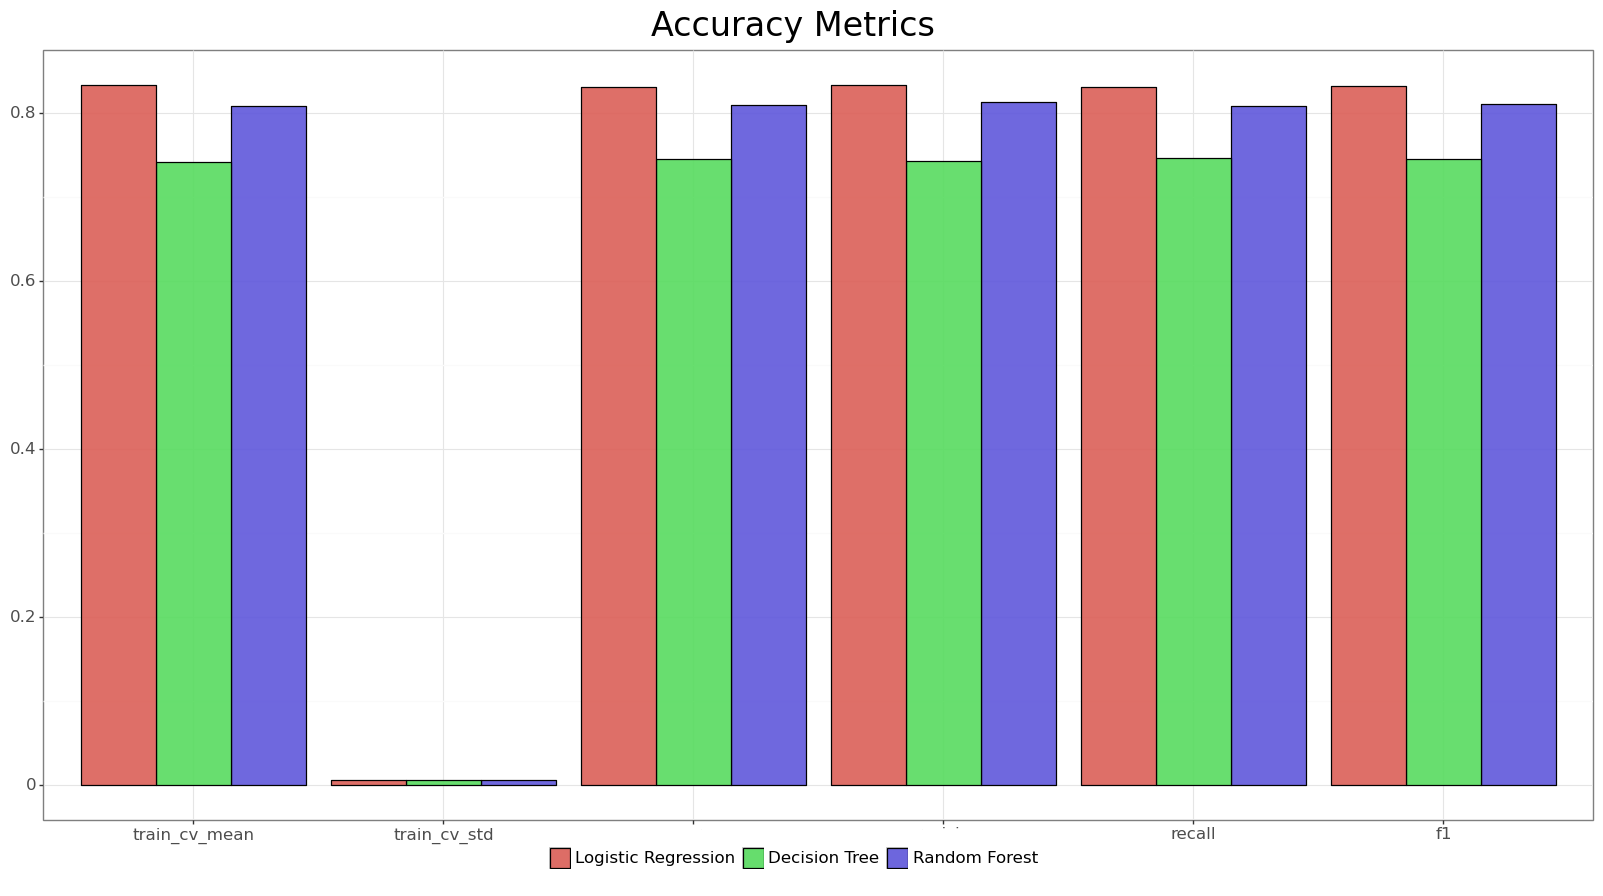

<ggplot: (127014637876)>

In [25]:
evaluation_df2 = evaluation_df.\
reset_index().\
rename(columns = {"index": "model"}).\
melt(id_vars = ["model"], 
     value_vars = ["train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"], 
     var_name = "metric", 
     value_name = "score").\
assign(model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", "Decision Tree", "Random Forest"]), 
       metric = lambda x: x.metric.astype("category").cat.reorder_categories(["train_cv_mean", "train_cv_std", "accuracy", 
                                                                              "precision", "recall", "f1"]), 
       score = lambda x: x.score.astype(float))

(ggplot(evaluation_df2, aes(x = "metric", y = "score", fill = "model")) + 
 geom_bar(stat = "identity", position = "dodge", color = "black", alpha = 0.9) + 
 scale_y_continuous() + 
 labs(title = "Accuracy Metrics", 
      x = "", 
      y = "") + 
 theme_bw() +
 theme(axis_text = element_text(size = 12), 
       legend_position = "bottom",
       legend_text = element_text(size = 12),
       legend_title = element_blank(), 
       plot_title = element_text(size = 24)))

Logistic regression performed the best in training accuracy and aevery test accuracy metric as well. Random Forest wasn't far off and the single Decision Tree was a distant third.

Definitions for evaluation metrics
* **Accuracy:** Percent of correctly predicted classes
* **Precision:** TP / (TP + FN)
* **Recall:** TP / (TP + FN)
* **F1:** 2 * (Precision * Recall) / (Precision + Recall)

## Precision/Recall Curve

It is already clear that Logistic Regression had the best Precision and Recall, but I'll plot it out for more detailed visualization.

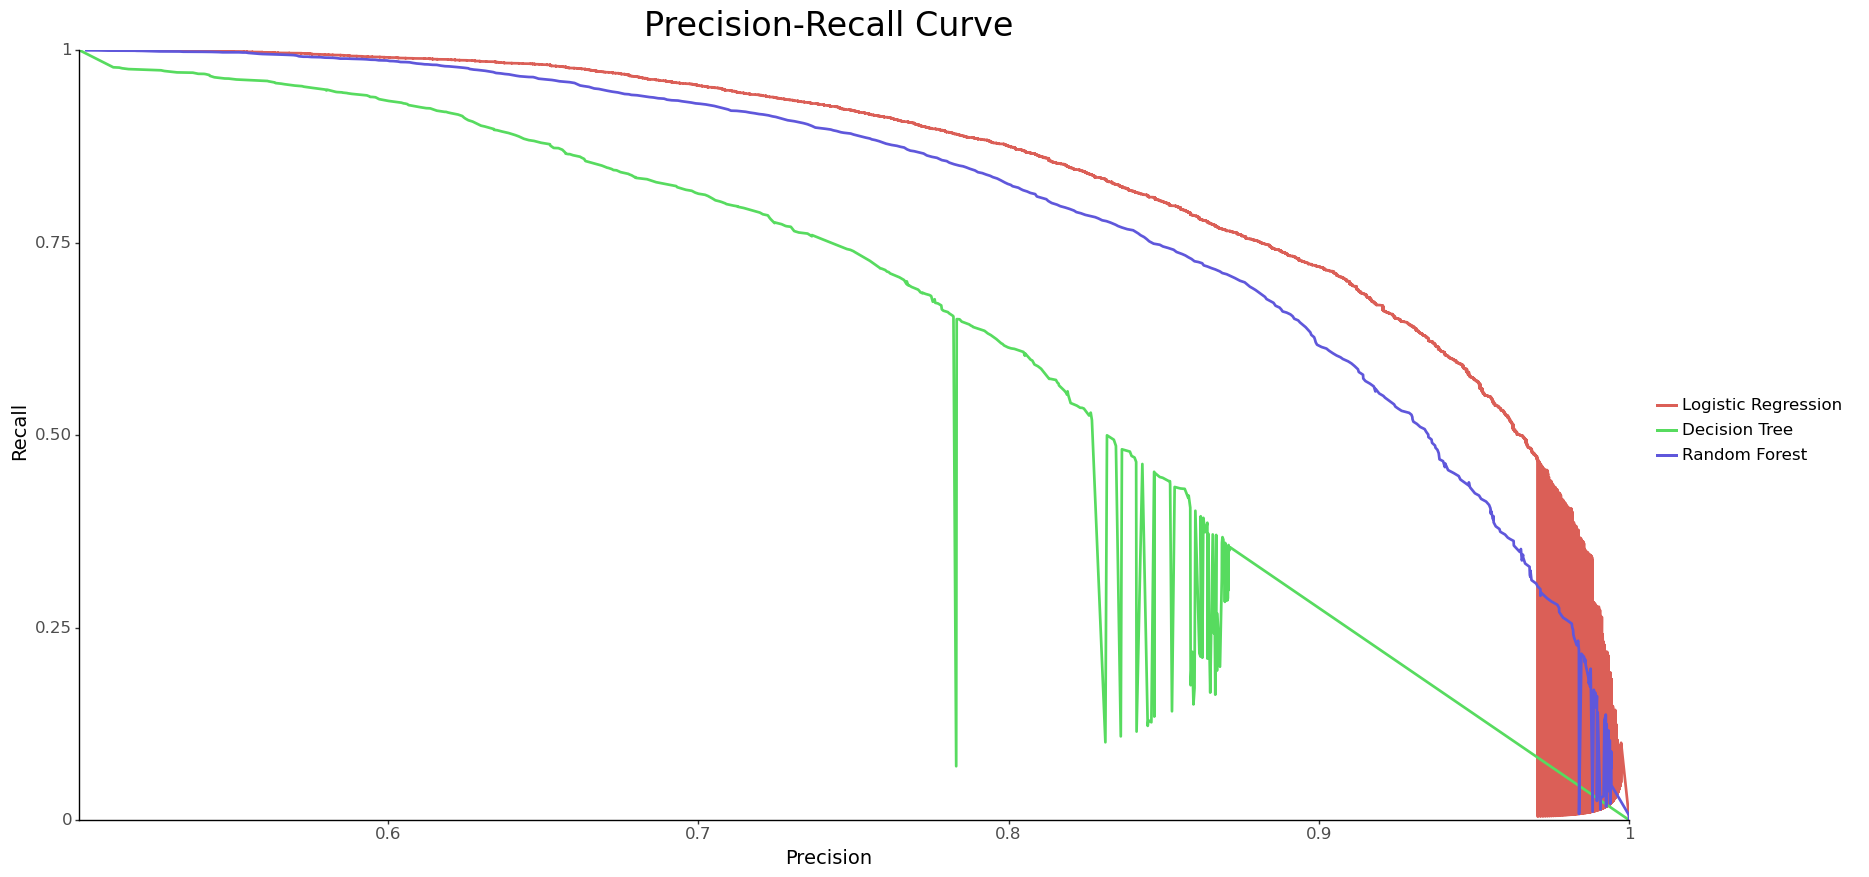

<ggplot: (127015874835)>

In [18]:
model_names = ["Logistic Regression", 
               "Decision Tree", 
               "Random Forest"]

predicted_probs = [log_reg.predict_proba(X_test_scaled)[:, 1],
                   dec_tree.predict_proba(X_test_scaled)[:, 1],
                   rand_for.predict_proba(X_test_scaled)[:, 1]]

pr_df = pd.DataFrame({"model": [], 
                      "precision" : [], 
                      "recall" : [],
                      "thresholds" : []})

for i in range(len(model_names)): 
    
    precision, recall, thresholds  = precision_recall_curve(y_test, predicted_probs[i], pos_label = "win")
    
    thresholds = np.append(thresholds, 0)
    
    pr_append_df = pd.DataFrame({"model": model_names[i], 
                                 "precision":precision, 
                                 "recall":recall, 
                                 "thresholds":thresholds})
    
    pr_df = pr_df.append(pr_append_df)
    
pr_df = pr_df.\
assign(model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", "Decision Tree", "Random Forest"]))

(ggplot(pr_df, aes(x = "precision", y = "recall", color = "model")) + 
 geom_line(size = 1.1) + 
 scale_x_continuous(expand = [0, 0]) + 
 scale_y_continuous(expand = [0, 0]) + 
 labs(title = "Precision-Recall Curve", 
      x = "Precision", 
      y = "Recall") + 
 theme_classic() +
 theme(axis_text = element_text(size = 12), 
       axis_title = element_text(size = 14),
       legend_position = "right",
       legend_text = element_text(size = 12),
       legend_title = element_blank(), 
       plot_title = element_text(size = 24)))

There are some wierd because some precision values appear twice but have different Recall values due to rounding, but the overall picture is still clear. Logistic Regression clearly has the best area under the curve, followed by Random Forest and Decision Tree in a distant third.

## ROC Curve
Now I will plot the ROC Curve. A again, I suspect this result to be similar to the other plots, but it will show more details.

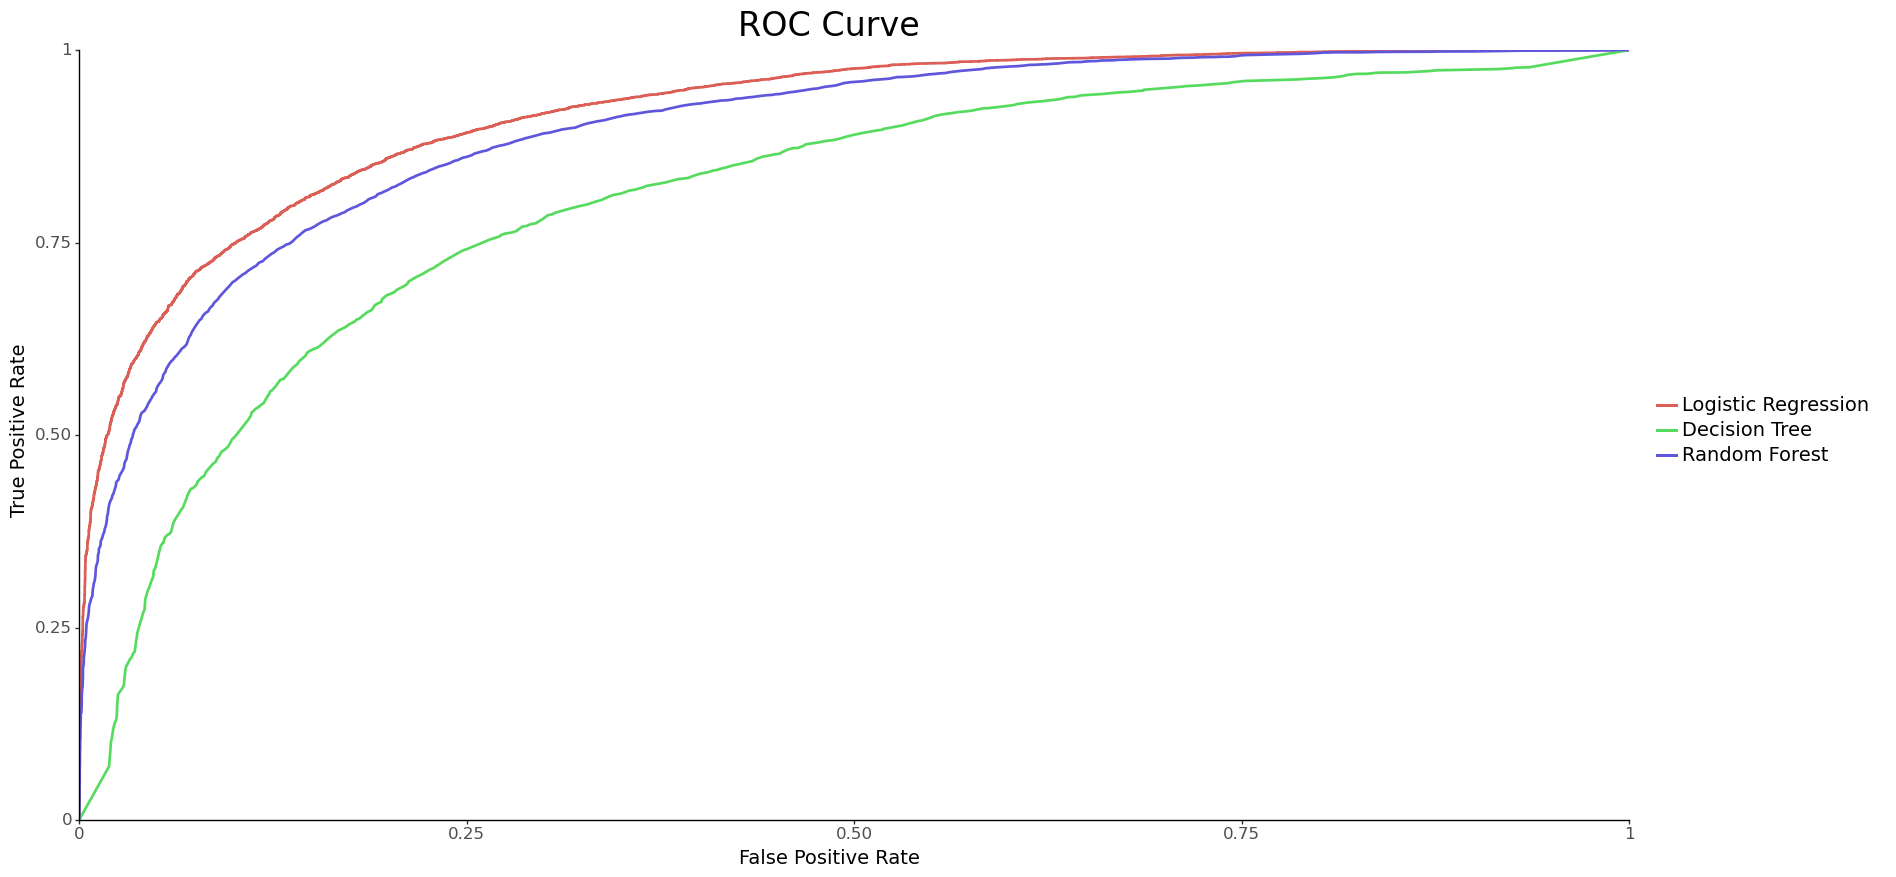

<ggplot: (127014741595)>

In [19]:
model_names = ["Logistic Regression", 
               "Decision Tree", 
               "Random Forest"]

predicted_probs = [log_reg.predict_proba(X_test_scaled)[:, 1],
                   dec_tree.predict_proba(X_test_scaled)[:, 1],
                   rand_for.predict_proba(X_test_scaled)[:, 1]]

roc_df = pd.DataFrame({"model": [], 
                       "fpr" : [], 
                       "tpr" : [],
                       "thresholds" : []})

for i in range(len(model_names)): 
    
    fpr, tpr, thresholds  = roc_curve(y_test, predicted_probs[i], pos_label = "win")
    
    roc_append_df = pd.DataFrame({"model": model_names[i],
                                  "auc": round(auc(fpr, tpr), 3).astype(str),
                                  "fpr":fpr, 
                                  "tpr":tpr, 
                                  "thresholds":thresholds})
    
    roc_df = roc_df.append(roc_append_df)

roc_df = roc_df.\
assign(model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", "Decision Tree", "Random Forest"]))

(ggplot(roc_df, aes(x = "fpr", y = "tpr", color = "model")) + 
 geom_line(size = 1.1) + 
 scale_x_continuous(expand = [0, 0]) + 
 scale_y_continuous(expand = [0, 0]) + 
 labs(title = "ROC Curve", 
      x = "False Positive Rate", 
      y = "True Positive Rate") + 
 theme_classic() +
 theme(axis_text = element_text(size = 12), 
       axis_title = element_text(size = 14), 
       legend_position = "right",
       legend_text = element_text(size = 14),
       legend_title = element_blank(), 
       plot_title = element_text(size = 24)))

Again, Logistic Regression had the best Area Under the Curve, followed by Random Forest and Decision Tree in a distant third. All ROC curves look normal too.

## Feature Importance
Now I will plot out the feature importances to clearly see which features were most important in building the models.

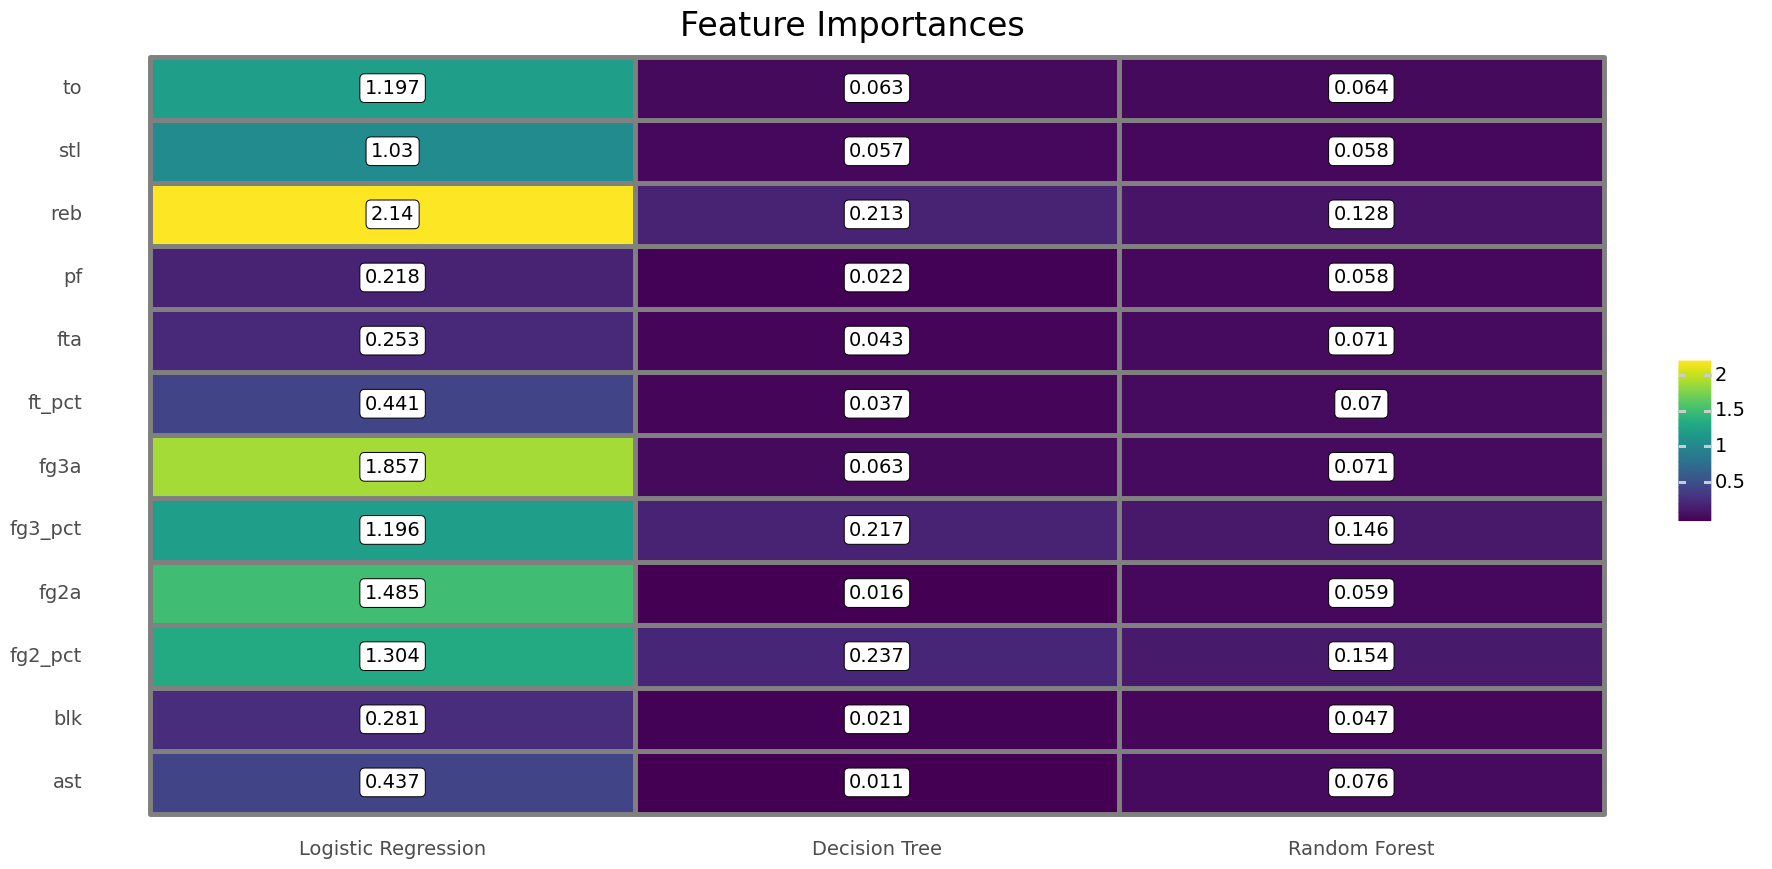

<ggplot: (127017065647)>

In [20]:
feature_list_df = pd.DataFrame({"Logistic Regression" : np.abs(np.std(X_train_scaled) * log_reg.coef_[0]).sort_values(ascending = False), 
                                "Decision Tree" : pd.Series(dec_tree.feature_importances_, index = dec_tree.feature_names_in_).sort_values(ascending = False),
                                "Random Forest" : pd.Series(rand_for.feature_importances_, index = rand_for.feature_names_in_).sort_values(ascending = False)}).reset_index().\
rename(columns = {"index" : "feature"}).\
melt(id_vars = ["feature"], 
     value_vars = ["Logistic Regression", "Decision Tree", "Random Forest"], 
     var_name = "model", 
     value_name = "importance").\
assign(lab_text = lambda x: np.round(x.importance, 3), 
       model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", "Decision Tree", "Random Forest"]))

(ggplot(feature_list_df, aes(x = "model", y = "feature", fill = "importance")) + 
 geom_tile(color = "grey", size = 2) +
 geom_label(aes(label = "lab_text"), fill = "white", size = 14) + 
 labs(title = "Feature Importances", 
      x = "", 
      y = "", 
      fill = "") + 
 theme_minimal() + 
 theme(axis_text_x = element_text(size = 14), 
       axis_text_y = element_text(size = 14), 
       legend_text = element_text(size = 14),
       panel_grid_major = element_blank(), 
       plot_title = element_text(size = 24)))

One thing to note is that Decision Tree and Random Forest have built-in feature importance attributes in their output. I had to manually create my own for Logistic Regression as it lack this attriubte. I suspect my manual calculation differs slightly from the built in one s for Decision Tree and Random Forest because Logistic Regression is getting much higher importances. Or it's possible that it's just the nature of the models. I'm not sure, but I already know I'm moving forward with Logistic Regression at this point so let's just look at that.

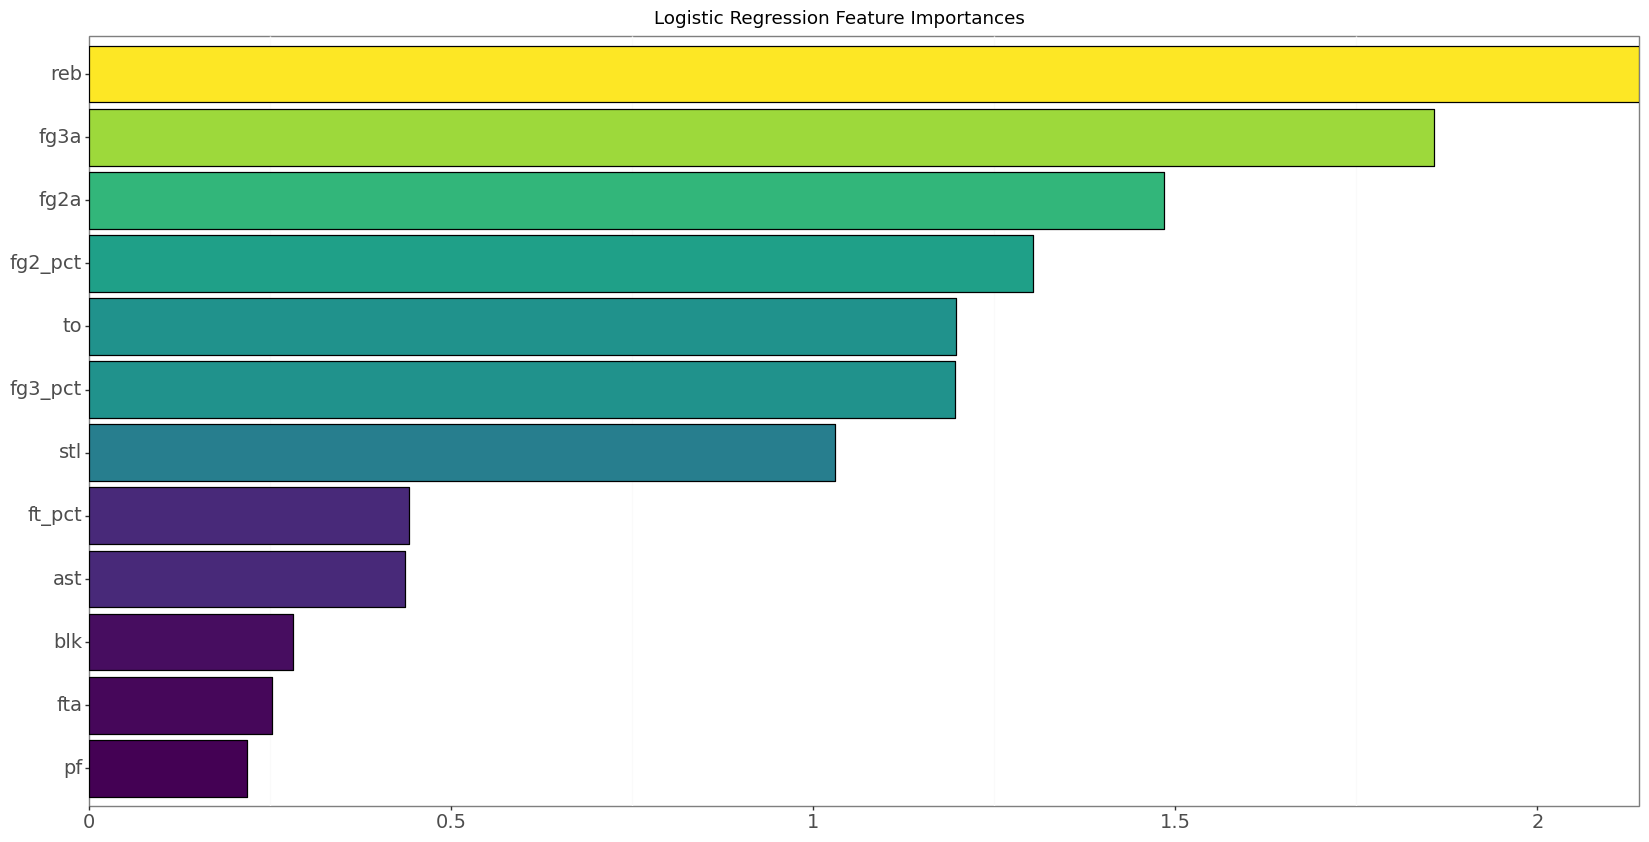

<ggplot: (127016964931)>

In [22]:
log_reg_features_df = feature_list_df.query("model == 'Logistic Regression'").\
assign(feature = lambda x: x.feature.astype("category").cat.reorder_categories(x.set_index("feature").sort_values("importance").index.tolist()))

(ggplot(log_reg_features_df, aes(x = "feature", y = "importance", fill = "importance")) + 
 geom_bar(stat = "identity", color = "black") + 
 coord_flip() + 
 scale_y_continuous(expand = [0, 0])+ 
 labs(title = "Logistic Regression Feature Importances", 
      x = "", 
      y = "", 
      fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 14), 
       axis_text_y = element_text(size = 14), 
       legend_position = "none",
       panel_grid_major = element_blank()))

The top 3 features are rebounds, 3-point attempts, and 2-point attempts. Random Forest and Decision Tree both also had rebounds in their top 3 but those models prefereed shooting percentage while logistic regression preferred attempts. I can see the model going one way or the other with attempts vs percentage based on the data. if teams generally shoot the same percent then the difference in winning comes down to who takes more shots. If teams generally take about the same amount of shots, then the difference in winning comes down to who made more of their shots.

In conclusion, I will use Logistic Regression as my final model and tell the hypothetical team I'm working for to focus on rebounding and creating shot opportunities.